In [3]:
%matplotlib inline
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

Loading and Processing the Data for the 2021-2022 Premier Leauge Season

In [4]:
url_prev = 'https://raw.githubusercontent.com/Sunan2002/Premier-Leauge-Prediction-Model/main/Season%20Datasets/ETraining.csv'
data = pd.read_csv(url_prev)
features = ['HomeTeam', 'AwayTeam', 'FTHG', 'FTAG','FTR', 'HTHG', 'HTAG', 
                 'HTR', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 
                 'AY', 'HR', 'AR','Referee']
fixtures = pd.concat([data], sort='False')
fixtures = fixtures[features]  
print(fixtures.shape)
fixtures.head()

(4560, 21)


<ipython-input-4-3d67cdadc0f5>:6: FutureWarning: Passing non boolean values for sort is deprecated and will error in a future version!
  fixtures = pd.concat([data], sort='False')


,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,HS,AS,...,AST,HF,AF,HC,AC,HY,AY,HR,AR,Referee
0,Brentford,Arsenal,2,0,H,1,0,H,8,22,...,4,12,8,2,5,0,0,0,0,M Oliver
1,Man United,Leeds,5,1,H,1,0,H,16,10,...,3,11,9,5,4,1,2,0,0,P Tierney
2,Burnley,Brighton,1,2,A,1,0,H,14,14,...,8,10,7,7,6,2,1,0,0,D Coote
3,Chelsea,Crystal Palace,3,0,H,2,0,H,13,4,...,1,15,11,5,2,0,0,0,0,J Moss
4,Everton,Southampton,3,1,H,0,1,A,14,6,...,3,13,15,6,8,2,0,0,0,A Madley


Appending a column that will indicate the result of each fixture, we will later use result as the target value for our match and season predictions

In [5]:
fixtures.tail()

,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,HS,AS,...,AST,HF,AF,HC,AC,HY,AY,HR,AR,Referee
4555,Newcastle,West Brom,3,3,D,2,0,H,15,13,...,7,5,8,7,6,0,0,0,0,M Halsey
4556,Stoke,Wigan,0,1,A,0,0,D,11,11,...,9,10,9,5,3,1,4,0,0,A Marriner
4557,Tottenham,Birmingham,2,1,H,0,0,D,22,7,...,3,5,15,7,5,0,3,0,0,M Clattenburg
4558,West Ham,Sunderland,0,3,A,0,1,A,17,17,...,12,7,8,4,6,0,2,0,0,A Taylor
4559,Wolves,Blackburn,2,3,A,0,3,A,12,13,...,10,12,9,8,3,3,1,0,0,H Webb


In [6]:
fixtures['FTR'].value_counts()

H    2044
A    1409
D    1107
Name: FTR, dtype: int64

In [7]:
encode_results = {"FTR": {"H": 0, "A": 1, "D":2}, "HTR": {"H": 0, "A": 1, "D":2}}
fixtures = fixtures.replace(encode_results)
fixtures.head()

,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,HS,AS,...,AST,HF,AF,HC,AC,HY,AY,HR,AR,Referee
0,Brentford,Arsenal,2,0,0,1,0,0,8,22,...,4,12,8,2,5,0,0,0,0,M Oliver
1,Man United,Leeds,5,1,0,1,0,0,16,10,...,3,11,9,5,4,1,2,0,0,P Tierney
2,Burnley,Brighton,1,2,1,1,0,0,14,14,...,8,10,7,7,6,2,1,0,0,D Coote
3,Chelsea,Crystal Palace,3,0,0,2,0,0,13,4,...,1,15,11,5,2,0,0,0,0,J Moss
4,Everton,Southampton,3,1,0,0,1,1,14,6,...,3,13,15,6,8,2,0,0,0,A Madley


In [8]:
fixtures.tail()

,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,HS,AS,...,AST,HF,AF,HC,AC,HY,AY,HR,AR,Referee
4555,Newcastle,West Brom,3,3,2,2,0,0,15,13,...,7,5,8,7,6,0,0,0,0,M Halsey
4556,Stoke,Wigan,0,1,1,0,0,2,11,11,...,9,10,9,5,3,1,4,0,0,A Marriner
4557,Tottenham,Birmingham,2,1,0,0,0,2,22,7,...,3,5,15,7,5,0,3,0,0,M Clattenburg
4558,West Ham,Sunderland,0,3,1,0,1,1,17,17,...,12,7,8,4,6,0,2,0,0,A Taylor
4559,Wolves,Blackburn,2,3,1,0,3,1,12,13,...,10,12,9,8,3,3,1,0,0,H Webb


# Home and Away Satistics Analysis per Team

In [9]:
home = fixtures.groupby('HomeTeam').mean() #Summation of each team's home goals (full and half time), shots, corners, cards
away = fixtures.groupby('AwayTeam').mean() #Summation of each team's away goals (full and half time), shots, corners, cards

<ipython-input-9-b51a7127131c>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  home = fixtures.groupby('HomeTeam').mean() #Summation of each team's home goals (full and half time), shots, corners, cards
<ipython-input-9-b51a7127131c>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  away = fixtures.groupby('AwayTeam').mean() #Summation of each team's away goals (full and half time), shots, corners, cards


In [10]:
home

,FTHG,FTAG,FTR,HTHG,HTAG,HTR,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR
HomeTeam,,,,,,,,,,,,,,,,,,
Arsenal,2.004386,0.899123,0.570175,0.850877,0.438596,1.061404,16.035088,9.899123,6.850877,3.798246,10.236842,11.530702,7.114035,4.289474,1.517544,1.934211,0.074561,0.109649
Aston Villa,1.187135,1.444444,0.970760,0.549708,0.660819,1.134503,12.263158,12.058480,4.795322,5.233918,10.982456,11.350877,5.631579,5.842105,1.660819,1.777778,0.093567,0.116959
Birmingham,1.000000,1.157895,1.105263,0.315789,0.368421,1.315789,9.578947,13.631579,4.052632,6.736842,10.105263,12.210526,4.684211,6.578947,1.263158,1.631579,0.105263,0.000000
Blackburn,1.263158,1.289474,0.868421,0.631579,0.500000,1.157895,12.921053,12.921053,6.552632,7.447368,12.000000,10.921053,5.052632,6.210526,1.657895,1.473684,0.052632,0.052632
Blackpool,1.578947,1.947368,1.000000,0.789474,1.000000,1.052632,13.315789,13.684211,7.052632,8.000000,11.368421,10.631579,4.947368,6.473684,1.157895,1.368421,0.000000,0.157895
Bolton,1.500000,1.657895,0.868421,0.578947,0.710526,0.973684,13.500000,13.000000,8.315789,7.763158,12.052632,10.105263,5.421053,6.026316,1.368421,1.552632,0.157895,0.026316
Bournemouth,1.431579,1.557895,0.905263,0.610526,0.726316,1.115789,12.536842,12.768421,4.200000,4.284211,9.178947,12.168421,5.684211,5.115789,1.600000,1.947368,0.052632,0.105263
Brentford,1.157895,1.105263,0.789474,0.315789,0.526316,1.368421,12.263158,11.578947,4.052632,3.789474,9.842105,9.631579,4.631579,5.631579,1.526316,1.157895,0.105263,0.052632
Brighton,1.094737,1.315789,1.094737,0.452632,0.589474,1.231579,12.926316,11.263158,3.568421,3.957895,10.957895,8.968421,5.526316,4.505263,1.663158,1.473684,0.052632,0.042105


In [11]:
away

,FTHG,FTAG,FTR,HTHG,HTAG,HTR,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR
AwayTeam,,,,,,,,,,,,,,,,,,
Arsenal,1.394737,1.583333,0.881579,0.671053,0.745614,1.092105,12.495614,12.539474,4.929825,5.307018,10.565789,9.771930,5.192982,5.074561,1.785088,1.675439,0.074561,0.127193
Aston Villa,1.725146,1.017544,0.701754,0.684211,0.502924,1.011696,15.192982,10.421053,6.017544,4.210526,11.678363,11.614035,6.479532,4.561404,1.590643,2.116959,0.064327,0.040936
Birmingham,1.894737,0.947368,0.842105,0.842105,0.473684,1.052632,16.000000,7.631579,9.736842,4.105263,11.105263,10.894737,6.473684,3.315789,1.368421,1.736842,0.157895,0.052632
Blackburn,2.315789,1.210526,0.631579,0.842105,0.526316,0.947368,16.368421,8.131579,8.921053,4.736842,9.789474,11.157895,7.921053,3.921053,1.552632,1.842105,0.052632,0.184211
Blackpool,2.157895,1.315789,0.684211,0.842105,0.684211,1.105263,19.473684,10.157895,10.578947,5.315789,9.736842,9.842105,7.526316,4.842105,1.210526,1.315789,0.000000,0.105263
Bolton,1.842105,1.078947,0.578947,0.605263,0.421053,1.157895,16.000000,11.368421,8.473684,6.157895,9.552632,11.868421,7.526316,5.447368,1.078947,1.736842,0.131579,0.105263
Bournemouth,1.915789,1.105263,0.610526,0.957895,0.578947,0.926316,14.768421,10.747368,5.084211,3.652632,11.094737,9.505263,6.063158,5.000000,1.821053,1.463158,0.115789,0.042105
Brentford,1.842105,1.368421,0.736842,1.000000,0.526316,0.736842,14.842105,11.000000,5.842105,4.052632,10.210526,9.684211,6.578947,3.736842,1.473684,1.684211,0.105263,0.052632
Brighton,1.400000,0.905263,0.831579,0.642105,0.421053,0.947368,14.726316,10.084211,4.515789,3.410526,8.957895,10.947368,6.305263,4.136842,1.400000,1.347368,0.031579,0.115789


In [12]:
team = pd.DataFrame()
team['Team'] = home.index

team = team.merge(home['FTHG'], left_on='Team', right_index=True)
team = team.merge(away['FTAG'], left_on='Team', right_index=True)

team = team.merge(home['FTAG'], left_on='Team', right_index=True)
team = team.merge(away['FTHG'], left_on='Team', right_index=True)

team = team.merge(home['HTHG'], left_on='Team', right_index=True)
team = team.merge(away['HTAG'], left_on='Team', right_index=True)

team = team.merge(home['HTAG'], left_on='Team', right_index=True)
team = team.merge(away['HTHG'], left_on='Team', right_index=True)

team = team.merge(home['HS'], left_on='Team', right_index=True)
team = team.merge(away['AS'], left_on='Team', right_index=True)

team = team.merge(home['HST'], left_on='Team', right_index=True)
team = team.merge(away['AST'], left_on='Team', right_index=True)

team = team.merge(home['HF'], left_on='Team', right_index=True)
team = team.merge(away['AF'], left_on='Team', right_index=True)

team = team.merge(home['HC'], left_on='Team', right_index=True)
team = team.merge(away['AC'], left_on='Team', right_index=True)

team = team.merge(home['HY'], left_on='Team', right_index=True)
team = team.merge(away['AY'], left_on='Team', right_index=True)

team = team.merge(home['HR'], left_on='Team', right_index=True)
team = team.merge(away['AR'], left_on='Team', right_index=True)

team.set_index('Team', inplace=True)
print(team.shape)
team

(38, 20)


,FTHG_x,FTAG_x,FTAG_y,FTHG_y,HTHG_x,HTAG_x,HTAG_y,HTHG_y,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR
Team,,,,,,,,,,,,,,,,,,,,
Arsenal,2.004386,1.583333,0.899123,1.394737,0.850877,0.745614,0.438596,0.671053,16.035088,12.539474,6.850877,5.307018,10.236842,9.771930,7.114035,5.074561,1.517544,1.675439,0.074561,0.127193
Aston Villa,1.187135,1.017544,1.444444,1.725146,0.549708,0.502924,0.660819,0.684211,12.263158,10.421053,4.795322,4.210526,10.982456,11.614035,5.631579,4.561404,1.660819,2.116959,0.093567,0.040936
Birmingham,1.000000,0.947368,1.157895,1.894737,0.315789,0.473684,0.368421,0.842105,9.578947,7.631579,4.052632,4.105263,10.105263,10.894737,4.684211,3.315789,1.263158,1.736842,0.105263,0.052632
Blackburn,1.263158,1.210526,1.289474,2.315789,0.631579,0.526316,0.500000,0.842105,12.921053,8.131579,6.552632,4.736842,12.000000,11.157895,5.052632,3.921053,1.657895,1.842105,0.052632,0.184211
Blackpool,1.578947,1.315789,1.947368,2.157895,0.789474,0.684211,1.000000,0.842105,13.315789,10.157895,7.052632,5.315789,11.368421,9.842105,4.947368,4.842105,1.157895,1.315789,0.000000,0.105263
Bolton,1.500000,1.078947,1.657895,1.842105,0.578947,0.421053,0.710526,0.605263,13.500000,11.368421,8.315789,6.157895,12.052632,11.868421,5.421053,5.447368,1.368421,1.736842,0.157895,0.105263
Bournemouth,1.431579,1.105263,1.557895,1.915789,0.610526,0.578947,0.726316,0.957895,12.536842,10.747368,4.200000,3.652632,9.178947,9.505263,5.684211,5.000000,1.600000,1.463158,0.052632,0.042105
Brentford,1.157895,1.368421,1.105263,1.842105,0.315789,0.526316,0.526316,1.000000,12.263158,11.000000,4.052632,4.052632,9.842105,9.684211,4.631579,3.736842,1.526316,1.684211,0.105263,0.052632
Brighton,1.094737,0.905263,1.315789,1.400000,0.452632,0.421053,0.589474,0.642105,12.926316,10.084211,3.568421,3.410526,10.957895,10.947368,5.526316,4.136842,1.663158,1.347368,0.052632,0.115789


In [13]:
matchup_col = ['HomeTeam', 'AwayTeam']
matchups = fixtures[matchup_col]
matchups = matchups.merge(team['FTHG_x'], left_on='HomeTeam', right_index=True, how='left')
matchups = matchups.merge(team['FTAG_x'], left_on='AwayTeam', right_index=True, how='left')
matchups = matchups.merge(team['FTAG_y'], left_on='HomeTeam', right_index=True, how='left')
matchups = matchups.merge(team['FTHG_y'], left_on='AwayTeam', right_index=True, how='left')
matchups = matchups.merge(team['HTHG_x'], left_on='HomeTeam', right_index=True, how='left')
matchups = matchups.merge(team['HTAG_x'], left_on='AwayTeam', right_index=True, how='left')
matchups = matchups.merge(team['HTAG_y'], left_on='HomeTeam', right_index=True, how='left')
matchups = matchups.merge(team['HTHG_y'], left_on='AwayTeam', right_index=True, how='left')
matchups = matchups.merge(team['HS'], left_on='HomeTeam', right_index=True, how='left')
matchups = matchups.merge(team['AS'], left_on='AwayTeam', right_index=True, how='left')
matchups = matchups.merge(team['HST'], left_on='HomeTeam', right_index=True, how='left')
matchups = matchups.merge(team['AST'], left_on='AwayTeam', right_index=True, how='left')
matchups = matchups.merge(team['HF'], left_on='HomeTeam', right_index=True, how='left')
matchups = matchups.merge(team['AF'], left_on='AwayTeam', right_index=True, how='left')
matchups = matchups.merge(team['HC'], left_on='HomeTeam', right_index=True, how='left')
matchups = matchups.merge(team['AC'], left_on='AwayTeam', right_index=True, how='left')
matchups = matchups.merge(team['HY'], left_on='HomeTeam', right_index=True, how='left')
matchups = matchups.merge(team['AY'], left_on='AwayTeam', right_index=True, how='left')
matchups = matchups.merge(team['HR'], left_on='HomeTeam', right_index=True, how='left')
matchups = matchups.merge(team['AR'], left_on='AwayTeam', right_index=True, how='left')
matchups['FTR'] = fixtures['FTR']
matchups

,HomeTeam,AwayTeam,FTHG_x,FTAG_x,FTAG_y,FTHG_y,HTHG_x,HTAG_x,HTAG_y,HTHG_y,...,AST,HF,AF,HC,AC,HY,AY,HR,AR,FTR
0,Brentford,Arsenal,1.157895,1.583333,1.105263,1.394737,0.315789,0.745614,0.526316,0.671053,...,5.307018,9.842105,9.771930,4.631579,5.074561,1.526316,1.675439,0.105263,0.127193,0
1,Man United,Leeds,1.973684,1.500000,0.912281,1.947368,0.934211,0.578947,0.337719,1.052632,...,4.500000,10.828947,11.394737,6.271930,4.947368,1.495614,1.973684,0.039474,0.052632,0
2,Burnley,Brighton,1.022556,0.905263,1.240602,1.400000,0.496241,0.421053,0.526316,0.642105,...,3.410526,10.293233,10.947368,4.744361,4.136842,1.624060,1.347368,0.000000,0.115789,1
3,Chelsea,Crystal Palace,1.991228,1.140351,0.894737,1.555556,0.942982,0.409357,0.359649,0.608187,...,3.368421,10.307018,11.649123,6.938596,4.502924,1.385965,1.736842,0.057018,0.052632,0
4,Everton,Southampton,1.609649,1.105263,1.131579,1.584211,0.714912,0.510526,0.491228,0.763158,...,4.326316,10.561404,11.505263,6.039474,5.226316,1.513158,1.668421,0.065789,0.052632,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4555,Newcastle,West Brom,1.397129,0.959064,1.325359,1.608187,0.602871,0.356725,0.574163,0.830409,...,3.935673,10.760766,11.093567,5.344498,4.046784,1.622010,1.760234,0.062201,0.081871,2
4556,Stoke,Wigan,1.328947,1.035088,1.164474,1.684211,0.611842,0.403509,0.526316,0.561404,...,6.017544,11.361842,11.438596,5.223684,4.070175,1.625000,1.964912,0.059211,0.122807,1
4557,Tottenham,Birmingham,1.859649,0.947368,0.934211,1.894737,0.828947,0.473684,0.403509,0.842105,...,4.105263,10.267544,10.894737,6.697368,3.315789,1.442982,1.736842,0.035088,0.052632,0
4558,West Ham,Sunderland,1.492823,1.000000,1.377990,1.721805,0.674641,0.428571,0.564593,0.669173,...,4.240602,9.990431,11.353383,5.464115,3.977444,1.516746,1.932331,0.043062,0.120301,1


In [14]:
X = matchups.drop(['HomeTeam','AwayTeam','FTR'], axis=1)
y = matchups["FTR"].values
X.head()

,FTHG_x,FTAG_x,FTAG_y,FTHG_y,HTHG_x,HTAG_x,HTAG_y,HTHG_y,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR
0,1.157895,1.583333,1.105263,1.394737,0.315789,0.745614,0.526316,0.671053,12.263158,12.539474,4.052632,5.307018,9.842105,9.771930,4.631579,5.074561,1.526316,1.675439,0.105263,0.127193
1,1.973684,1.500000,0.912281,1.947368,0.934211,0.578947,0.337719,1.052632,15.535088,12.578947,6.657895,4.500000,10.828947,11.394737,6.271930,4.947368,1.495614,1.973684,0.039474,0.052632
2,1.022556,0.905263,1.240602,1.400000,0.496241,0.421053,0.526316,0.642105,11.315789,10.084211,3.631579,3.410526,10.293233,10.947368,4.744361,4.136842,1.624060,1.347368,0.000000,0.115789
3,1.991228,1.140351,0.894737,1.555556,0.942982,0.409357,0.359649,0.608187,17.206140,10.157895,7.118421,3.368421,10.307018,11.649123,6.938596,4.502924,1.385965,1.736842,0.057018,0.052632
4,1.609649,1.105263,1.131579,1.584211,0.714912,0.510526,0.491228,0.763158,13.885965,11.947368,5.600877,4.326316,10.561404,11.505263,6.039474,5.226316,1.513158,1.668421,0.065789,0.052632


In [15]:
y

array([0, 0, 1, ..., 0, 1, 1])

# Normalizing the Data

In [17]:
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit(X).transform(X.astype(float))
X

array([[-0.88256807,  1.04331009, -0.40979062, ..., -0.34900301,
         1.72050345,  1.66564854],
       [ 1.03965279,  0.80732328, -1.1310221 , ...,  1.4488913 ,
        -0.65807275, -0.90853557],
       [-1.20146186, -0.87687729,  0.09600809, ..., -2.32668677,
        -2.08521846,  1.27194979],
       ...,
       [ 0.77095525, -0.75764185, -1.04906398, ...,  0.0211517 ,
        -0.81664449, -0.90853557],
       [-0.09338649, -0.60859755,  0.60947041, ...,  1.19960344,
        -0.52833223,  1.42769875],
       [-0.61387053, -0.01242036,  0.80318961, ...,  0.65570263,
        -0.81664449,  3.63414227]])

# Training the Model

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)
print("y_train: ", y_train.shape)
print("y_test: ", y_test.shape)

X_train:  (3648, 20)
X_test:  (912, 20)
y_train:  (3648,)
y_test:  (912,)


In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)
xgb = XGBClassifier(max_depth=2, n_estimators=100)
xgb.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

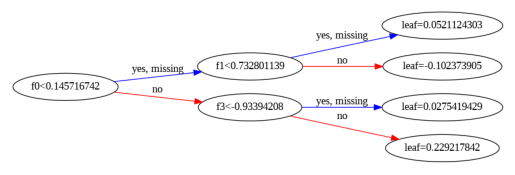

In [32]:
from xgboost import plot_tree
plot_tree(xgb, num_trees=0, rankdir='LR')
plt.show()

In [29]:
from sklearn.model_selection import GridSearchCV
optimization_dict = {'max_depth': [2,4,6,8,10,12], 'n_estimators': [50,100,200,400]}
model = GridSearchCV(xgb, optimization_dict, scoring='accuracy', verbose=1) # cv = 5 by default

In [30]:
model.fit(X_train, y_train)
print("Params: ", model.best_params_)
print("Score: ", model.best_score_)
print("Estimator: ", model.best_estimator_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Params:  {'max_depth': 2, 'n_estimators': 100}
Score:  0.5246740703158765
Estimator:  XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)


In [33]:
pd.concat([pd.DataFrame(model.cv_results_["params"]),pd.DataFrame(model.cv_results_["mean_test_score"], columns=["Accuracy"])],axis=1)

,max_depth,n_estimators,Accuracy
0,2,50,0.524672
1,2,100,0.524674
2,2,200,0.515353
3,2,400,0.504938
4,4,50,0.509874
5,4,100,0.491233
6,4,200,0.480814
7,4,400,0.470667
8,6,50,0.477253
9,6,100,0.469025


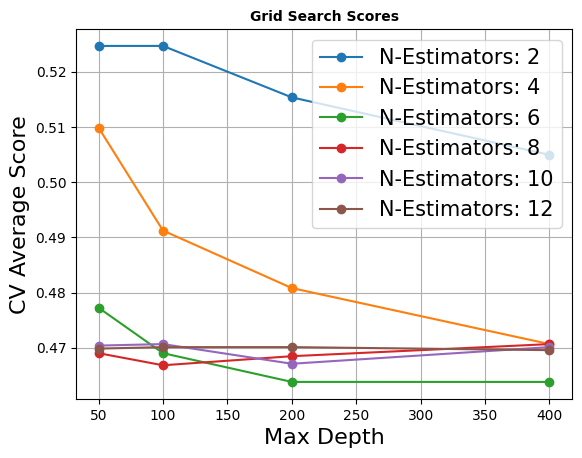

In [34]:
# Visualization Code Taken From: https://stackoverflow.com/questions/37161563/how-to-graph-grid-scores-from-gridsearchcv

def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1)

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores", fontsize=10, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.legend(loc="best", fontsize=15)
    ax.grid('on')

# Calling Method 
plot_grid_search(model.cv_results_, [50,100,200,400],
                 [2,4,6,8,10,12], 'Max Depth', 'N-Estimators')

In [36]:
prediction = model.predict(X_test)
acc_score = accuracy_score(y_test, prediction)
print("Past 12 Seasons Accuracy Score: ", acc_score)

Past 12 Seasons Accuracy Score:  0.5109649122807017


In [59]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, f1_score, precision_score, recall_score

prec_score,recall_score,f_score,support = precision_recall_fscore_support(y_test, prediction, average='weighted')
print("Precision =", prec_score)
print("Recall =", recall_score)
print("F1_Score =", f_score)

Precision = 0.4671158051705393
Recall = 0.5109649122807017
F1_Score = 0.4625724101290509


Text(113.9222222222222, 0.5, 'predicted label')

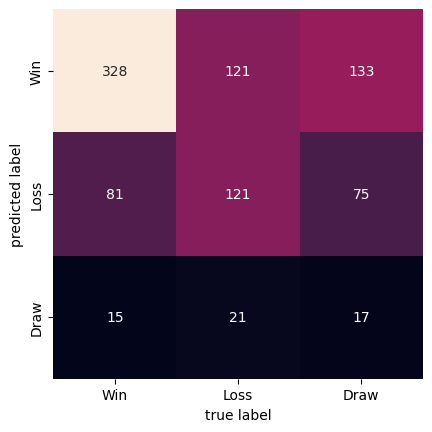

In [38]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

mat = confusion_matrix(y_test, prediction)
sns.heatmap(mat.T, square=True, annot=True, fmt='d',
cbar=False, xticklabels=['Win', 'Loss', 'Draw'], yticklabels=['Win', 'Loss', 'Draw'])
plt.xlabel('true label')
plt.ylabel('predicted label')

In [39]:
predicted = pd.DataFrame(model.predict(X), columns=['Predicted'])
fixtures['Predicted'] = predicted 
fixtures

,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,HS,AS,...,HF,AF,HC,AC,HY,AY,HR,AR,Referee,Predicted
0,Brentford,Arsenal,2,0,0,1,0,0,8,22,...,12,8,2,5,0,0,0,0,M Oliver,1
1,Man United,Leeds,5,1,0,1,0,0,16,10,...,11,9,5,4,1,2,0,0,P Tierney,0
2,Burnley,Brighton,1,2,1,1,0,0,14,14,...,10,7,7,6,2,1,0,0,D Coote,0
3,Chelsea,Crystal Palace,3,0,0,2,0,0,13,4,...,15,11,5,2,0,0,0,0,J Moss,0
4,Everton,Southampton,3,1,0,0,1,1,14,6,...,13,15,6,8,2,0,0,0,A Madley,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4555,Newcastle,West Brom,3,3,2,2,0,0,15,13,...,5,8,7,6,0,0,0,0,M Halsey,0
4556,Stoke,Wigan,0,1,1,0,0,2,11,11,...,10,9,5,3,1,4,0,0,A Marriner,0
4557,Tottenham,Birmingham,2,1,0,0,0,2,22,7,...,5,15,7,5,0,3,0,0,M Clattenburg,0
4558,West Ham,Sunderland,0,3,1,0,1,1,17,17,...,7,8,4,6,0,2,0,0,A Taylor,0


# Predicted vs Actual Outcomes for the past 12 seasons

In [40]:
def calculate_points_prev(home, away, result, table, col):
  if result == 2:
    # print("Draw")
    table.loc[home,col] += 1
    table.loc[away,col] += 1
  elif result == 0:
    # print(home + " Win")
    table.loc[home,col] += 3
  elif result == 1:
    # print(away + " Win")
    table.loc[away,col] += 3
  # print(home + ": " + str(table_2122.loc[home,col]))
  # print(away + ": " + str(table_2122.loc[away,col]))
  # print("\n\n")

In [41]:
year = 21
x = 0
for i in range(12):
  title = "Table for " + str(year) + "-" + str(year+1) + " Season"
  print(title)
  table = pd.DataFrame(index=fixtures.HomeTeam.unique())
  table['Final_Points'] = 0
  table['Predicted_Points'] = 0
  for index, row in (fixtures[x:x+379]).iterrows():
    calculate_points_prev(row.HomeTeam,row.AwayTeam,row.FTR,table,'Final_Points')
    calculate_points_prev(row.HomeTeam,row.AwayTeam,row.Predicted,table,'Predicted_Points')
  table = table[table.Final_Points != 0]
  table = table.sort_values(by='Final_Points', ascending=0)
  year -= 1
  x += 380
  display(table)

Table for 21-22 Season


,Final_Points,Predicted_Points
Man City,93,108
Liverpool,92,99
Chelsea,74,99
Arsenal,69,93
Tottenham,68,87
Man United,58,99
West Ham,56,55
Leicester,52,72
Brighton,51,23
Wolves,51,41


Table for 20-21 Season


,Final_Points,Predicted_Points
Man City,86,108
Man United,71,96
Liverpool,69,99
Chelsea,67,99
Leicester,66,72
West Ham,65,58
Tottenham,62,90
Arsenal,61,93
Leeds,59,53
Everton,59,68


Table for 19-20 Season


,Final_Points,Predicted_Points
Liverpool,99,99
Man City,81,108
Man United,66,99
Chelsea,66,99
Leicester,62,69
Tottenham,59,90
Wolves,59,41
Arsenal,56,93
Sheffield United,54,27
Burnley,54,34


Table for 18-19 Season


,Final_Points,Predicted_Points
Man City,98,108
Liverpool,97,99
Chelsea,72,99
Tottenham,71,90
Arsenal,70,93
Man United,66,99
Wolves,57,40
Everton,54,64
Leicester,52,69
Watford,50,24


Table for 17-18 Season


,Final_Points,Predicted_Points
Man City,100,108
Man United,81,99
Tottenham,77,90
Liverpool,75,99
Chelsea,70,99
Arsenal,63,93
Burnley,54,34
Everton,49,58
Leicester,47,69
Newcastle,44,39


Table for 16-17 Season


,Final_Points,Predicted_Points
Chelsea,93,99
Tottenham,86,90
Liverpool,76,99
Man City,75,105
Arsenal,75,93
Man United,69,99
Everton,61,58
Bournemouth,46,36
Southampton,46,54
West Ham,45,52


Table for 15-16 Season


,Final_Points,Predicted_Points
Leicester,81,69
Arsenal,71,93
Tottenham,70,90
Man City,66,108
Man United,63,96
Southampton,63,54
West Ham,62,51
Liverpool,60,99
Stoke,51,40
Chelsea,50,99


Table for 14-15 Season


,Final_Points,Predicted_Points
Chelsea,87,99
Man City,79,108
Arsenal,75,93
Man United,70,99
Tottenham,64,90
Liverpool,62,96
Southampton,60,52
Swansea,56,37
Stoke,51,38
Crystal Palace,48,35


Table for 13-14 Season


,Final_Points,Predicted_Points
Man City,86,108
Liverpool,84,99
Chelsea,82,99
Arsenal,79,93
Everton,72,62
Tottenham,69,90
Man United,64,99
Southampton,56,60
Newcastle,49,46
Stoke,47,42


Table for 12-13 Season


,Final_Points,Predicted_Points
Man United,89,99
Man City,78,108
Chelsea,75,99
Arsenal,73,93
Tottenham,72,88
Everton,63,61
Liverpool,61,97
West Brom,49,33
West Ham,46,51
Swansea,46,44


Table for 11-12 Season


,Final_Points,Predicted_Points
Man United,89,99
Man City,89,106
Arsenal,70,93
Tottenham,69,90
Newcastle,65,43
Chelsea,64,99
Everton,56,65
Fulham,52,36
Liverpool,52,99
Swansea,47,43


Table for 10-11 Season


,Final_Points,Predicted_Points
Man United,80,97
Man City,71,104
Chelsea,71,97
Arsenal,68,93
Tottenham,62,88
Liverpool,58,97
Everton,54,65
Fulham,49,37
Aston Villa,48,29
West Brom,47,36


# Predicting Current Season Standings and Final Projections

In [42]:
url_curr = 'https://raw.githubusercontent.com/Sunan2002/Premier-Leauge-Prediction-Model/main/Season%20Datasets/ECurrent.csv'
data_curr = pd.read_csv(url_curr)
fixtures_curr = pd.concat([data_curr], sort='False')
fixtures_curr = fixtures_curr[features]  
fixtures_curr.shape

<ipython-input-42-716df2de5db1>:3: FutureWarning: Passing non boolean values for sort is deprecated and will error in a future version!
  fixtures_curr = pd.concat([data_curr], sort='False')


(296, 21)

In [43]:
fixtures_curr.head()

,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,HS,AS,...,AST,HF,AF,HC,AC,HY,AY,HR,AR,Referee
0,Crystal Palace,Arsenal,0,2,A,0,1,A,10,10,...,2,16,11,3,5,1,2,0,0,A Taylor
1,Fulham,Liverpool,2,2,D,1,0,H,9,11,...,4,7,9,4,4,2,0,0,0,A Madley
2,Bournemouth,Aston Villa,2,0,H,1,0,H,7,15,...,2,18,16,5,5,3,3,0,0,P Bankes
3,Leeds,Wolves,2,1,H,1,1,D,12,15,...,6,13,9,6,4,2,0,0,0,R Jones
4,Newcastle,Nott'm Forest,2,0,H,0,0,D,23,5,...,0,9,14,11,1,0,3,0,0,S Hooper


In [44]:
fixtures_curr.tail()

,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,HS,AS,...,AST,HF,AF,HC,AC,HY,AY,HR,AR,Referee
291,Tottenham,Brighton,2,1,H,1,1,D,9,17,...,4,15,15,3,7,3,1,0,0,S Attwell
292,Wolves,Chelsea,1,0,H,1,0,H,9,13,...,1,14,10,8,8,2,5,0,0,P Bankes
293,Southampton,Man City,1,4,A,0,1,A,4,13,...,8,6,10,0,10,0,2,0,0,R Jones
294,Leeds,Crystal Palace,1,5,A,1,1,D,11,16,...,8,11,8,2,4,3,1,0,0,S Hooper
295,Liverpool,Arsenal,2,2,D,1,2,A,21,9,...,5,11,11,5,4,4,4,0,0,P Tierney


In [45]:
fixtures_curr = fixtures_curr.replace(encode_results)
fixtures_curr

,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,HS,AS,...,AST,HF,AF,HC,AC,HY,AY,HR,AR,Referee
0,Crystal Palace,Arsenal,0,2,1,0,1,1,10,10,...,2,16,11,3,5,1,2,0,0,A Taylor
1,Fulham,Liverpool,2,2,2,1,0,0,9,11,...,4,7,9,4,4,2,0,0,0,A Madley
2,Bournemouth,Aston Villa,2,0,0,1,0,0,7,15,...,2,18,16,5,5,3,3,0,0,P Bankes
3,Leeds,Wolves,2,1,0,1,1,2,12,15,...,6,13,9,6,4,2,0,0,0,R Jones
4,Newcastle,Nott'm Forest,2,0,0,0,0,2,23,5,...,0,9,14,11,1,0,3,0,0,S Hooper
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291,Tottenham,Brighton,2,1,0,1,1,2,9,17,...,4,15,15,3,7,3,1,0,0,S Attwell
292,Wolves,Chelsea,1,0,0,1,0,0,9,13,...,1,14,10,8,8,2,5,0,0,P Bankes
293,Southampton,Man City,1,4,1,0,1,1,4,13,...,8,6,10,0,10,0,2,0,0,R Jones
294,Leeds,Crystal Palace,1,5,1,1,1,2,11,16,...,8,11,8,2,4,3,1,0,0,S Hooper


# Generating the Data for the Matches already played this season

In [46]:
home_played = fixtures_curr.groupby('HomeTeam').mean() #Mean of each team's home goals (full and half time), shots, corners, cards
away_played = fixtures_curr.groupby('AwayTeam').mean() #Mean of each team's away goals (full and half time), shots, corners, cards

<ipython-input-46-5a9829d6d9ef>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  home_played = fixtures_curr.groupby('HomeTeam').mean() #Mean of each team's home goals (full and half time), shots, corners, cards
<ipython-input-46-5a9829d6d9ef>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  away_played = fixtures_curr.groupby('AwayTeam').mean() #Mean of each team's away goals (full and half time), shots, corners, cards


In [47]:
team_form = pd.DataFrame()
team_form['Team'] = home_played.index

team_form = team_form.merge(home_played['FTHG'], left_on='Team', right_index=True)
team_form = team_form.merge(away_played['FTAG'], left_on='Team', right_index=True)

team_form = team_form.merge(home_played['FTAG'], left_on='Team', right_index=True)
team_form = team_form.merge(away_played['FTHG'], left_on='Team', right_index=True)

team_form = team_form.merge(home_played['HTHG'], left_on='Team', right_index=True)
team_form = team_form.merge(away_played['HTAG'], left_on='Team', right_index=True)

team_form = team_form.merge(home_played['HTAG'], left_on='Team', right_index=True)
team_form = team_form.merge(away_played['HTHG'], left_on='Team', right_index=True)

team_form = team_form.merge(home_played['HS'], left_on='Team', right_index=True)
team_form = team_form.merge(away_played['AS'], left_on='Team', right_index=True)

team_form = team_form.merge(home_played['HST'], left_on='Team', right_index=True)
team_form = team_form.merge(away_played['AST'], left_on='Team', right_index=True)

team_form = team_form.merge(home_played['HF'], left_on='Team', right_index=True)
team_form = team_form.merge(away_played['AF'], left_on='Team', right_index=True)

team_form = team_form.merge(home_played['HC'], left_on='Team', right_index=True)
team_form = team_form.merge(away_played['AC'], left_on='Team', right_index=True)

team_form = team_form.merge(home_played['HY'], left_on='Team', right_index=True)
team_form = team_form.merge(away_played['AY'], left_on='Team', right_index=True)

team_form = team_form.merge(home_played['HR'], left_on='Team', right_index=True)
team_form = team_form.merge(away_played['AR'], left_on='Team', right_index=True)

team_form.set_index('Team', inplace=True)
print(team_form.shape)
team_form

(20, 20)


,FTHG_x,FTAG_x,FTAG_y,FTHG_y,HTHG_x,HTAG_x,HTAG_y,HTHG_y,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR
Team,,,,,,,,,,,,,,,,,,,,
Arsenal,2.800000,2.000000,1.200000,0.733333,0.933333,1.133333,0.400000,0.266667,19.000000,13.266667,6.466667,4.333333,9.466667,9.666667,7.066667,5.000000,1.000000,1.866667,0.000000,0.000000
Aston Villa,1.666667,1.066667,1.266667,1.400000,0.933333,0.400000,0.600000,0.800000,11.733333,10.800000,4.666667,3.600000,9.866667,12.600000,4.266667,3.733333,1.733333,2.200000,0.000000,0.066667
Bournemouth,1.000000,0.866667,1.266667,2.533333,0.466667,0.400000,0.800000,1.200000,9.933333,8.200000,3.466667,3.400000,11.266667,9.600000,4.133333,3.466667,1.733333,1.866667,0.000000,0.000000
Brentford,1.933333,1.200000,1.066667,1.600000,1.066667,0.533333,0.333333,0.933333,11.466667,9.133333,4.800000,3.600000,8.933333,9.666667,4.600000,4.066667,1.266667,1.400000,0.066667,0.000000
Brighton,1.785714,1.928571,1.000000,1.571429,0.714286,1.000000,0.571429,0.642857,17.000000,13.571429,7.142857,4.857143,10.642857,10.714286,7.785714,4.928571,1.571429,1.071429,0.000000,0.000000
Chelsea,1.066667,0.866667,0.800000,1.266667,0.266667,0.533333,0.133333,0.800000,13.400000,11.933333,4.000000,4.066667,10.533333,11.000000,6.533333,5.133333,2.133333,2.066667,0.066667,0.133333
Crystal Palace,0.933333,1.000000,1.266667,1.400000,0.266667,0.466667,0.466667,0.533333,11.466667,10.066667,3.333333,3.733333,12.200000,11.666667,4.533333,4.333333,2.066667,2.333333,0.133333,0.066667
Everton,0.866667,0.666667,1.133333,1.733333,0.333333,0.266667,0.400000,0.800000,12.266667,9.000000,4.533333,2.733333,9.666667,10.733333,5.133333,3.733333,2.000000,2.266667,0.066667,0.000000
Fulham,1.400000,1.285714,1.400000,1.357143,0.533333,0.500000,0.866667,0.428571,13.000000,10.000000,4.266667,3.642857,9.866667,11.714286,5.800000,3.714286,1.466667,3.357143,0.066667,0.000000


In [48]:
played = fixtures_curr[matchup_col]
played = played.merge(team_form['FTHG_x'], left_on='HomeTeam', right_index=True, how='left')
played = played.merge(team_form['FTAG_x'], left_on='AwayTeam', right_index=True, how='left')
played = played.merge(team_form['FTAG_y'], left_on='HomeTeam', right_index=True, how='left')
played = played.merge(team_form['FTHG_y'], left_on='AwayTeam', right_index=True, how='left')
played = played.merge(team_form['HTHG_x'], left_on='HomeTeam', right_index=True, how='left')
played = played.merge(team_form['HTAG_x'], left_on='AwayTeam', right_index=True, how='left')
played = played.merge(team_form['HTAG_y'], left_on='HomeTeam', right_index=True, how='left')
played = played.merge(team_form['HTHG_y'], left_on='AwayTeam', right_index=True, how='left')
played = played.merge(team_form['HS'], left_on='HomeTeam', right_index=True, how='left')
played = played.merge(team_form['AS'], left_on='AwayTeam', right_index=True, how='left')
played = played.merge(team_form['HST'], left_on='HomeTeam', right_index=True, how='left')
played = played.merge(team_form['AST'], left_on='AwayTeam', right_index=True, how='left')
played = played.merge(team_form['HF'], left_on='HomeTeam', right_index=True, how='left')
played = played.merge(team_form['AF'], left_on='AwayTeam', right_index=True, how='left')
played = played.merge(team_form['HC'], left_on='HomeTeam', right_index=True, how='left')
played = played.merge(team_form['AC'], left_on='AwayTeam', right_index=True, how='left')
played = played.merge(team_form['HY'], left_on='HomeTeam', right_index=True, how='left')
played = played.merge(team_form['AY'], left_on='AwayTeam', right_index=True, how='left')
played = played.merge(team_form['HR'], left_on='HomeTeam', right_index=True, how='left')
played = played.merge(team_form['AR'], left_on='AwayTeam', right_index=True, how='left')
played['FTR'] = fixtures_curr['FTR']
played

,HomeTeam,AwayTeam,FTHG_x,FTAG_x,FTAG_y,FTHG_y,HTHG_x,HTAG_x,HTAG_y,HTHG_y,...,AST,HF,AF,HC,AC,HY,AY,HR,AR,FTR
0,Crystal Palace,Arsenal,0.933333,2.000000,1.266667,0.733333,0.266667,1.133333,0.466667,0.266667,...,4.333333,12.200000,9.666667,4.533333,5.000000,2.066667,1.866667,0.133333,0.000000,1
1,Fulham,Liverpool,1.400000,0.933333,1.400000,1.600000,0.533333,0.533333,0.866667,0.666667,...,5.066667,9.866667,10.400000,5.800000,5.666667,1.466667,1.666667,0.066667,0.000000,2
2,Bournemouth,Aston Villa,1.000000,1.066667,1.266667,1.400000,0.466667,0.400000,0.800000,0.800000,...,3.600000,11.266667,12.600000,4.133333,3.733333,1.733333,2.200000,0.000000,0.066667,0
3,Leeds,Wolves,1.400000,0.733333,1.600000,1.533333,0.666667,0.333333,0.733333,0.533333,...,3.000000,12.733333,12.666667,6.000000,4.133333,1.866667,2.133333,0.066667,0.133333,0
4,Newcastle,Nott'm Forest,1.642857,0.333333,0.642857,2.400000,0.571429,0.133333,0.285714,1.000000,...,2.266667,10.857143,10.933333,7.714286,4.400000,1.571429,1.933333,0.071429,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291,Tottenham,Brighton,2.066667,1.928571,1.133333,1.571429,0.666667,1.000000,0.800000,0.642857,...,4.857143,12.333333,10.714286,5.800000,4.928571,2.333333,1.071429,0.066667,0.000000,0
292,Wolves,Chelsea,0.866667,0.866667,1.266667,1.266667,0.466667,0.533333,0.466667,0.800000,...,4.066667,10.866667,11.000000,5.600000,5.133333,2.066667,2.066667,0.200000,0.133333,0
293,Southampton,Man City,1.000000,1.866667,1.866667,0.866667,0.333333,0.733333,0.600000,0.266667,...,5.400000,10.933333,9.466667,4.866667,5.733333,1.400000,1.333333,0.000000,0.000000,1
294,Leeds,Crystal Palace,1.400000,1.000000,1.600000,1.400000,0.666667,0.466667,0.733333,0.533333,...,3.733333,12.733333,11.666667,6.000000,4.333333,1.866667,2.333333,0.066667,0.066667,1


# Merging current form data with fixtures to be played, and predicting their outcomes

In [49]:
url_future = 'https://raw.githubusercontent.com/Sunan2002/Premier-Leauge-Prediction-Model/main/England-Premier-League-Season-2022-2023-Fixture.csv'
data_fut = pd.read_csv(url_future)
fixtures_fut = pd.concat([data_fut], sort='False')
fixtures_fut = fixtures_fut.rename(columns={"Home": "HomeTeam", "Away": "AwayTeam"}) 
print(fixtures_fut.shape)
fixtures_fut

(380, 7)


<ipython-input-49-660b727d8f31>:3: FutureWarning: Passing non boolean values for sort is deprecated and will error in a future version!
  fixtures_fut = pd.concat([data_fut], sort='False')


,AwayTeam,Date,HomeTeam,League,Month,Nation,Year
0,Arsenal,5,Crystal Palace,Premier League,8,England,2022
1,Aston Villa,6,Bournemouth,Premier League,8,England,2022
2,Chelsea,6,Everton,Premier League,8,England,2022
3,Liverpool,6,Fulham,Premier League,8,England,2022
4,Wolves,6,Leeds,Premier League,8,England,2022
...,...,...,...,...,...,...,...
375,Bournemouth,28,Everton,Premier League,5,England,2023
376,Tottenham,28,Leeds,Premier League,5,England,2023
377,West Ham,28,Leicester,Premier League,5,England,2023
378,Fulham,28,Man United,Premier League,5,England,2023


In [50]:
fixtures_fut = fixtures_fut[296:]
fixtures_fut

,AwayTeam,Date,HomeTeam,League,Month,Nation,Year
296,Everton,8,Man United,Premier League,4,England,2023
297,Man City,8,Southampton,Premier League,4,England,2023
298,Brighton,8,Tottenham,Premier League,4,England,2023
299,Chelsea,8,Wolves,Premier League,4,England,2023
300,Newcastle,15,Aston Villa,Premier League,4,England,2023
...,...,...,...,...,...,...,...
375,Bournemouth,28,Everton,Premier League,5,England,2023
376,Tottenham,28,Leeds,Premier League,5,England,2023
377,West Ham,28,Leicester,Premier League,5,England,2023
378,Fulham,28,Man United,Premier League,5,England,2023


In [51]:
fixtures_fut = fixtures_fut[['HomeTeam','AwayTeam']]
fixtures_fut

,HomeTeam,AwayTeam
296,Man United,Everton
297,Southampton,Man City
298,Tottenham,Brighton
299,Wolves,Chelsea
300,Aston Villa,Newcastle
...,...,...
375,Everton,Bournemouth
376,Leeds,Tottenham
377,Leicester,West Ham
378,Man United,Fulham


In [52]:
to_be_played = fixtures_fut
to_be_played = to_be_played.merge(team_form['FTHG_x'], left_on='HomeTeam', right_index=True, how='left')
to_be_played = to_be_played.merge(team_form['FTAG_x'], left_on='AwayTeam', right_index=True, how='left')
to_be_played = to_be_played.merge(team_form['FTAG_y'], left_on='HomeTeam', right_index=True, how='left')
to_be_played = to_be_played.merge(team_form['FTHG_y'], left_on='AwayTeam', right_index=True, how='left')
to_be_played = to_be_played.merge(team_form['HTHG_x'], left_on='HomeTeam', right_index=True, how='left')
to_be_played = to_be_played.merge(team_form['HTAG_x'], left_on='AwayTeam', right_index=True, how='left')
to_be_played = to_be_played.merge(team_form['HTAG_y'], left_on='HomeTeam', right_index=True, how='left')
to_be_played = to_be_played.merge(team_form['HTHG_y'], left_on='AwayTeam', right_index=True, how='left')
to_be_played = to_be_played.merge(team_form['HS'], left_on='HomeTeam', right_index=True, how='left')
to_be_played = to_be_played.merge(team_form['AS'], left_on='AwayTeam', right_index=True, how='left')
to_be_played = to_be_played.merge(team_form['HST'], left_on='HomeTeam', right_index=True, how='left')
to_be_played = to_be_played.merge(team_form['AST'], left_on='AwayTeam', right_index=True, how='left')
to_be_played = to_be_played.merge(team_form['HF'], left_on='HomeTeam', right_index=True, how='left')
to_be_played = to_be_played.merge(team_form['AF'], left_on='AwayTeam', right_index=True, how='left')
to_be_played = to_be_played.merge(team_form['HC'], left_on='HomeTeam', right_index=True, how='left')
to_be_played = to_be_played.merge(team_form['AC'], left_on='AwayTeam', right_index=True, how='left')
to_be_played = to_be_played.merge(team_form['HY'], left_on='HomeTeam', right_index=True, how='left')
to_be_played = to_be_played.merge(team_form['AY'], left_on='AwayTeam', right_index=True, how='left')
to_be_played = to_be_played.merge(team_form['HR'], left_on='HomeTeam', right_index=True, how='left')
to_be_played = to_be_played.merge(team_form['AR'], left_on='AwayTeam', right_index=True, how='left')
#played['FTR'] = fixtures_curr['FTR']
to_be_played

,HomeTeam,AwayTeam,FTHG_x,FTAG_x,FTAG_y,FTHG_y,HTHG_x,HTAG_x,HTAG_y,HTHG_y,...,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR
296,Man United,Everton,1.800000,0.666667,0.533333,1.733333,0.666667,0.266667,0.200000,0.800000,...,5.733333,2.733333,10.600000,10.733333,6.200000,3.733333,1.866667,2.266667,0.066667,0.000000
297,Southampton,Man City,1.000000,1.866667,1.866667,0.866667,0.333333,0.733333,0.600000,0.266667,...,4.200000,5.400000,10.933333,9.466667,4.866667,5.733333,1.400000,1.333333,0.000000,0.000000
298,Tottenham,Brighton,2.066667,1.928571,1.133333,1.571429,0.666667,1.000000,0.800000,0.642857,...,5.933333,4.857143,12.333333,10.714286,5.800000,4.928571,2.333333,1.071429,0.066667,0.000000
299,Wolves,Chelsea,0.866667,0.866667,1.266667,1.266667,0.466667,0.533333,0.466667,0.800000,...,3.733333,4.066667,10.866667,11.000000,5.600000,5.133333,2.066667,2.066667,0.200000,0.133333
300,Aston Villa,Newcastle,1.666667,1.666667,1.266667,0.800000,0.933333,0.933333,0.600000,0.400000,...,4.666667,4.533333,9.866667,10.133333,4.266667,6.000000,1.733333,1.600000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,Everton,Bournemouth,0.866667,0.866667,1.133333,2.533333,0.333333,0.400000,0.400000,1.200000,...,4.533333,3.400000,9.666667,9.600000,5.133333,3.466667,2.000000,1.866667,0.066667,0.000000
376,Leeds,Tottenham,1.400000,1.600000,1.600000,1.666667,0.666667,0.600000,0.733333,0.466667,...,4.533333,4.400000,12.733333,10.533333,6.000000,5.000000,1.866667,1.733333,0.066667,0.133333
377,Leicester,West Ham,1.133333,0.571429,1.333333,1.428571,0.800000,0.285714,0.733333,0.500000,...,3.866667,3.214286,10.866667,10.642857,3.800000,5.571429,1.266667,1.357143,0.133333,0.000000
378,Man United,Fulham,1.800000,1.285714,0.533333,1.357143,0.666667,0.500000,0.200000,0.428571,...,5.733333,3.642857,10.600000,11.714286,6.200000,3.714286,1.866667,3.357143,0.066667,0.000000


In [54]:
final_matches = to_be_played.drop(['HomeTeam','AwayTeam'], axis=1)
projection = model.predict(final_matches)
projection

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [55]:
to_be_played['Prediction'] = projection
to_be_played

,HomeTeam,AwayTeam,FTHG_x,FTAG_x,FTAG_y,FTHG_y,HTHG_x,HTAG_x,HTAG_y,HTHG_y,...,AST,HF,AF,HC,AC,HY,AY,HR,AR,Prediction
296,Man United,Everton,1.800000,0.666667,0.533333,1.733333,0.666667,0.266667,0.200000,0.800000,...,2.733333,10.600000,10.733333,6.200000,3.733333,1.866667,2.266667,0.066667,0.000000,0
297,Southampton,Man City,1.000000,1.866667,1.866667,0.866667,0.333333,0.733333,0.600000,0.266667,...,5.400000,10.933333,9.466667,4.866667,5.733333,1.400000,1.333333,0.000000,0.000000,0
298,Tottenham,Brighton,2.066667,1.928571,1.133333,1.571429,0.666667,1.000000,0.800000,0.642857,...,4.857143,12.333333,10.714286,5.800000,4.928571,2.333333,1.071429,0.066667,0.000000,0
299,Wolves,Chelsea,0.866667,0.866667,1.266667,1.266667,0.466667,0.533333,0.466667,0.800000,...,4.066667,10.866667,11.000000,5.600000,5.133333,2.066667,2.066667,0.200000,0.133333,0
300,Aston Villa,Newcastle,1.666667,1.666667,1.266667,0.800000,0.933333,0.933333,0.600000,0.400000,...,4.533333,9.866667,10.133333,4.266667,6.000000,1.733333,1.600000,0.000000,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,Everton,Bournemouth,0.866667,0.866667,1.133333,2.533333,0.333333,0.400000,0.400000,1.200000,...,3.400000,9.666667,9.600000,5.133333,3.466667,2.000000,1.866667,0.066667,0.000000,0
376,Leeds,Tottenham,1.400000,1.600000,1.600000,1.666667,0.666667,0.600000,0.733333,0.466667,...,4.400000,12.733333,10.533333,6.000000,5.000000,1.866667,1.733333,0.066667,0.133333,0
377,Leicester,West Ham,1.133333,0.571429,1.333333,1.428571,0.800000,0.285714,0.733333,0.500000,...,3.214286,10.866667,10.642857,3.800000,5.571429,1.266667,1.357143,0.133333,0.000000,0
378,Man United,Fulham,1.800000,1.285714,0.533333,1.357143,0.666667,0.500000,0.200000,0.428571,...,3.642857,10.600000,11.714286,6.200000,3.714286,1.866667,3.357143,0.066667,0.000000,0


# Generating Final Season Standings Projections

In [58]:
def calculate_points(home, away, result, table, col):
  if result == 2:
    # print("Draw")
    table.loc[home,col] += 1
    table.loc[away,col] += 1
  elif result == 0:
    # print(home + " Win")
    table.loc[home,col] += 3
  elif result == 1:
    # print(away + " Win")
    table.loc[away,col] += 3
  # print(home + ": " + str(table_2122.loc[home,col]))
  # print(away + ": " + str(table_2122.loc[away,col]))
  # print("\n\n")


title = "Table Prediction for 22-23 Season"
print(title)
table = pd.DataFrame(index=home_played.index)
table['Predicted Points'] = 0
for index, row in (played).iterrows():
  calculate_points(row.HomeTeam,row.AwayTeam,row.FTR,table,'Predicted Points')
for index, row in (to_be_played).iterrows():
  calculate_points(row.HomeTeam,row.AwayTeam,row.Prediction,table,'Predicted Points')
table = table.sort_values(by='Predicted Points', ascending=0)
year -= 1
x += 380
display(table)

Table Prediction for 22-23 Season


,Predicted Points
HomeTeam,
Arsenal,85
Man City,82
Man United,71
Tottenham,68
Newcastle,68
Aston Villa,59
Brighton,58
Liverpool,56
Brentford,55
